In [1]:
%pip install gymnasium pyvirtualdisplay > /dev/null 2>&1
%pip install pygame
%pip install -Uqq ipdb
%pip install gymnasium
%pip install opencv-python
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00


In [ ]:
pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
%pdb on

Automatic pdb calling has been turned ON


In [3]:
class FrozenLake(gym.Env):
  def __init__(self, grid_width, grid_height, grid_description):
      self.width = grid_width
      self.height = grid_height
      self.description = grid_description
      self.observation_space = spaces.Discrete(self.width * self.height)
      self.action_space = spaces.Discrete(4)  # up, down, right, left
      self.actions = {0:(0,-1), 1:(0,1), 2:(1,0), 3:(-1,0)} # up, down, right, left
      self.agent_location = [0, 0]  # agent starts at top-left corner
      self.rewards = {} # position, corresponding reward

      # creates the grid using the description
      self.grid = np.array(list(grid_description)).reshape(grid_width, grid_height)
      self.rewards = np.zeros_like(self.grid, dtype=np.int32)
      self.rewards[self.grid == 'I'] = 0 # ice - award of 0
      self.rewards[self.grid == 'H'] = -100 # hole - reward of -100
      self.rewards[self.grid == 'G'] = 100 # goal - reward of 100

  def _get_obs(self):
    return self.agent_location

  def reset(self, seed=None, options=None):
    super().reset(seed=seed)
    self.agent_location = (0, 0)
    row, col = self._get_obs()
    return (row, col)

  def compute_reward(self, observation):
      return self.rewards[(observation[0], observation[1])]

  def step(self, action):
      observation = self._get_obs()

      def take_action(action):
        new_observation = tuple(x + y for x, y in zip(observation, self.actions[action]))
        # updates the agent's location if it's within the grid and the new location isn't a hole
        if 0 <= new_observation[0] < self.width and 0 <= new_observation[1] < self.height:
            self.agent_location = new_observation

      def is_episode_over():
        row, col = self.agent_location
        cell = self.grid[row][col]
        if cell == 'H' or cell == 'G': # episode ends if agent reaches the goal or falls into a hole
            return True
        return False

      take_action(action) # processes the action parameter on the board
      observation = self._get_obs() # observation after taking action
      reward = self.compute_reward(observation)
      terminated = is_episode_over() # true if episode completed and false otherwise

      return observation, reward, terminated, False, None

  def _render_frame(self, screen, window_width, window_height):
    pass

  def render(self, screen, window_width, window_height):
    pygame.init()

    # window dimensions
    window_width = self.width * 50
    window_height = self.height * 50

    # colors
    white = (255, 255, 255)
    black = (0, 0, 0)
    blue = (0, 0, 255)
    red = (255, 0, 0)

    # creates the window
    screen = pygame.display.set_mode((window_width, window_height))
    pygame.display.set_caption('Grid World Environment')

    # default screen
    screen.fill(white)

    # draws the grid based on the description
    for i, block_type in enumerate(self.description):
        row = i // self.width
        col = i % self.width
        x = col * 50
        y = row * 50

        if block_type == 'I': # Ice block
            pygame.draw.rect(screen, blue, (x, y, 50, 50))
        elif block_type == 'H': # Hole
            pygame.draw.rect(screen, black, (x, y, 50, 50))
        elif block_type == 'G': # Goal
            pygame.draw.circle(screen, red, (x + 25, y + 25), 20)

    # draws the agent
    agent_row, agent_col = self.agent_location
    agent_x = agent_col * 50 + 25
    agent_y = agent_row * 50 + 25
    pygame.draw.circle(screen, black, (agent_x, agent_y), 10)

    # updates the display
    pygame.display.update()

    # event loop
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()

    return self._render_frame(screen, window_width, window_height)

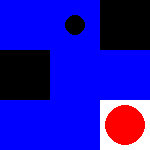

In [6]:
from google.colab.patches import cv2_imshow

# Your code to read and process the image

# Display the image
cv2_imshow(img_bgr)


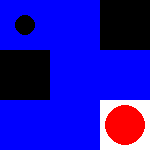

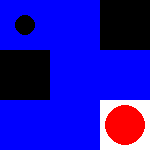

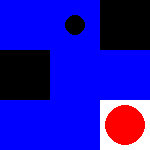

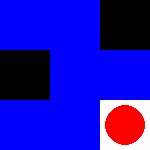

In [10]:
from google.colab.patches import cv2_imshow
import pygame
import numpy as np
import time

# Assuming FrozenLake, pygame, and lake objects are defined earlier in your code

# Initialize Pygame display
window_width = 400
window_height = 400
pygame.init()
screen = pygame.display.set_mode((window_width, window_height))

for i in range(1):
    lake.reset()
    terminated = False
    while not terminated:
        action = lake.action_space.sample()
        observation, reward, terminated, truncated, info = lake.step(action)
        lake.render(screen, window_width, window_height)

        # Convert Pygame surface to numpy array and then to BGR format
        view = pygame.surfarray.array3d(screen)
        view = np.transpose(view, (1, 0, 2))
        img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

        # Display the image
        cv2_imshow(img_bgr)
        time.sleep(0.5)


In [11]:
import random

class QLearning():
    def __init__(self, env, exploration, gamma, alpha, obs_space_n, action_space_n):
        self.env = env
        self.exploration = exploration
        self.gamma = gamma
        self.alpha = alpha
        self.obs_space_n = obs_space_n
        self.action_space_n = action_space_n

        # initializes q-table with rewards from FrozenLake class
        self.q_table = np.zeros((env.width, env.height, action_space_n))
        self.q_table[:, :, :] = env.rewards[:, :, np.newaxis]

    def sample_action(self, observation):
        if random.uniform(0, 1) < self.exploration:
            return random.randint(0, self.action_space_n - 1) # random action
        else:
            return np.argmax(self.q_table[observation[0], observation[1]])

    def update_table(self, observation, action, reward, new_observation, terminated):
        current_q_value = self.q_table[observation[0], observation[1], action]
        if terminated:
            target_q_value = reward
        else:
            max_future_q_value = np.max(self.q_table[new_observation[0], new_observation[1]])
            target_q_value = reward + self.gamma * max_future_q_value
        new_q_value = ((1 - self.alpha) * current_q_value) + (self.alpha * target_q_value)
        self.q_table[observation[0], observation[1], action] = new_q_value

In [12]:
lake = FrozenLake(5, 5, "IIIHIHIHHHIIIIGIIIIHIIIIH")
q_learning = QLearning(lake, .3, .99, .9, lake.width * lake.height, lake.action_space.n)

# trains the policy using QLearning
num_episodes = 100000
for episode in range(num_episodes):
    for row in range(lake.width):
        for col in range(lake.height):
            observation = (row, col)
            if lake.grid[row][col] == 'I':
                action = q_learning.sample_action(observation)
                new_observation = tuple(x + y for x, y in zip(observation, lake.actions[action]))
                if not (0 <= new_observation[0] < lake.width and 0 <= new_observation[1] < lake.height): # if out of bounds, no change
                    new_observation = observation
                q_learning.update_table(observation, action, 0, new_observation, False) # updates the Q-table

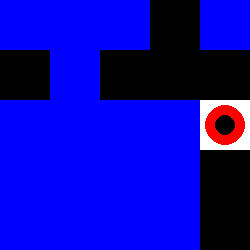

In [14]:
from google.colab.patches import cv2_imshow
import pygame
import numpy as np
import time
from IPython.display import clear_output

q_learning.exploration = 0.0

# Assuming lake object is defined earlier in your code

# Initialize Pygame display
window_width = 400
window_height = 400
pygame.init()
screen = pygame.display.set_mode((window_width, window_height))

for i in range(1):
    observation = lake.reset()
    terminated = False
    lake.render(screen, window_width, window_height)

    while not terminated:
        action = q_learning.sample_action(observation)
        observation, reward, terminated, truncated, info = lake.step(action)
        lake.render(screen, window_width, window_height)

        # Convert Pygame surface to numpy array and then to BGR format
        view = pygame.surfarray.array3d(screen)
        view = np.transpose(view, (1, 0, 2))
        img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)

        # Display the image
        cv2_imshow(img_bgr)
        time.sleep(0.5)
        clear_output(wait=True)
